Mounted at /content/gdrive
Found 12000 images belonging to 50 classes.
Found 3000 images belonging to 50 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
375/375 [==============================] - 4281s 11s/step - loss: 3.3787 - accuracy: 0.1360 - val_loss: 2.6334 - val_accuracy: 0.3550
Epoch 2/10
375/375 [==============================] - 782s 2s/step - loss: 2.6571 - accuracy: 0.2621 - val_loss: 2.0964 - val_accuracy: 0.4723
Epoch 3/10
375/375 [==============================] - 761s 2s/step - loss: 2.3615 - accuracy: 0.3272 - val_loss: 1.8933 - val_accuracy: 0.5303
Epoch 4/10
375/375 [==============================] - 752s 2s/step - loss: 2.2134 - accuracy: 0.3602 - val_loss: 1.6781 - val_accuracy: 0.5670
Epoch 5/10
375/375 [==============================] - 750s 2s/step - loss: 2.1182 - accuracy: 0.3842 - val_loss: 1.6011 - val_accuracy: 0.5887
Epoch 6/10
375/375 [==============================] - 747s 2s/step - loss: 2.0343 - accuracy: 0.4123 - val

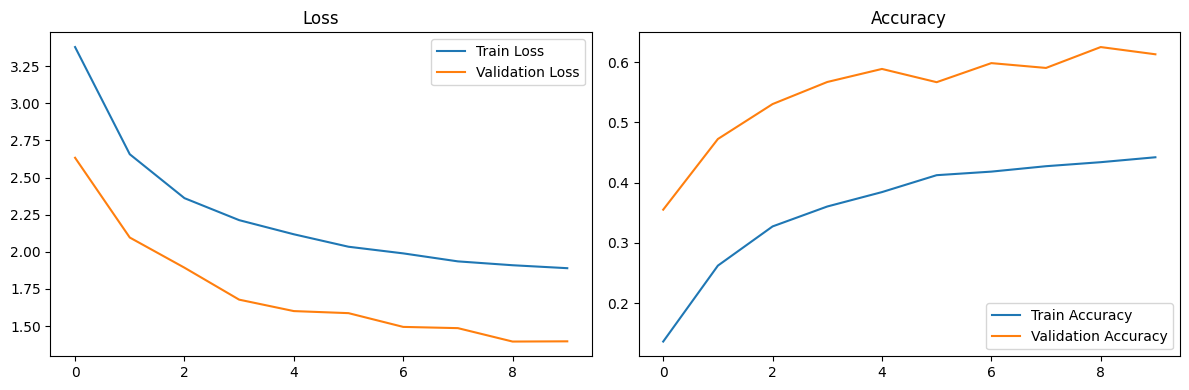

94/94 [==============================] - 121s 1s/step - loss: 1.3975 - accuracy: 0.6130
Test Loss: 1.3975 - Test Accuracy: 0.6130


In [2]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/gdrive')



# Define dataset directory
dataset_dir = '/content/gdrive/My Drive/dataset'

# Configure GPU visibility
tf.config.experimental.set_visible_devices([], 'GPU')

# Define target size and batch size
target_size = (224, 224)
batch_size = 32

# Load training data using ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'Train'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

# Load test data using ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'Test'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

# Load MobileNetV2 model with custom top layers
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/gdrive/My Drive/best_model.h5', save_best_only=True)

# Train the model with callbacks
epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator

)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")
